In [ ]:
# Unzipping script
# import os
# import gzip
# import shutil

# current_directory = os.getcwd()

# for file_name in os.listdir(current_directory):
#     if file_name.endswith('.gz'):
#         gz_file_path = os.path.join(current_directory, file_name)
#         unzipped_file_path = os.path.splitext(gz_file_path)[0]

#         with gzip.open(gz_file_path, 'rb') as gz_file:
#             with open(unzipped_file_path, 'wb') as unzipped_file:
#                 shutil.copyfileobj(gz_file, unzipped_file)

#         os.remove(gz_file_path)

#         print(f"Unzipped: {unzipped_file_path}")

In [17]:
# Accumulate df
import os
import netCDF4 as nc
import pandas as pd
import numpy as np

current_directory = os.getcwd()

data = {}

for file_name in os.listdir(os.path.join(current_directory, 'data')):
    if file_name.endswith('.nc'):
        nc_file = nc.Dataset(os.path.join(current_directory, 'data', file_name))

        for var_name, var in nc_file.variables.items():
            if var_name in data:
                data[var_name] = np.concatenate((data[var_name], var[:]))
            else:
                data[var_name] = var[:]
        nc_file.close()

df = pd.DataFrame(data)

In [ ]:
df.columns
important_columns_presumably = ['bt', 'bx_gse', 'by_gse', 'bz_gse', 'theta_gse', 'phi_gse']
df[df["bt"]!=-99999][:1000].plot(x="time", y=important_columns_presumably[0])
plt.show()

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=3)
fig.set_figheight(8)
fig.set_figwidth(15)

for i in range(2):
    for j in range(3):
        df[df["bt"]!=-99999][:].plot(x="time", y=important_columns_presumably[i*3+j], ax=axes[i, j])
plt.show()

In [18]:
#preprocessing
import datetime
df['time'] = df['time'].apply(lambda x: datetime.datetime.fromtimestamp(x/1000))
#flags with all same bool
df.drop(['backfill_flag', 'future_packet_time_flag', 'maneuver_flag', 'calibration_mode_flag', 'possible_saturation_flag'], axis=1, inplace=True)
df.drop(['measurement_range', 'measurement_mode', 'overall_quality'], axis=1, inplace=True)
#drop gsm coordinate system
df.drop(['bx_gsm', 'by_gsm', 'bz_gsm', 'theta_gsm', 'phi_gsm'], axis=1, inplace=True)
#check flags to set mask and then drop flags
df['mask'] = 1
df.loc[(df['old_packet_time_flag'] == 1) | (df['fill_flag'] == 1) | (df['low_sample_count_flag'] == 1), 'mask'] = 0
df.drop(['old_packet_time_flag', 'fill_flag', 'low_sample_count_flag'], axis=1, inplace=True)
#drop all rows with mask 0
df.loc[df['mask'] == 0, ['sample_count', 'bt', 'bx_gse', 'by_gse', 'bz_gse', 'theta_gse', 'phi_gse']] = 0

#fourier feature encoding for date information
df['year'] = df['time'].dt.year
df['month'] = df['time'].dt.month
df['day'] = df['time'].dt.day
df['hour'] = df['time'].dt.hour
df['minute'] = df['time'].dt.minute
df.drop(['time'], axis=1, inplace=True)

periods = {
    'year': 365.25,
    'month': 12,
    'day': 30.44,
    'hour': 24,
    'minute': 60
}

for component, period in periods.items():
    df[f'{component}_cos'] = df[component].apply(lambda x: np.cos(x * 2 * np.pi / period))
    df[f'{component}_sin'] = df[component].apply(lambda x: np.sin(x * 2 * np.pi / period))

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, data_frame, window_size):
        self.data = torch.tensor(data_frame[['bt', 'bx_gse', 'by_gse', 'bz_gse', 'theta_gse', 'phi_gse']].values)
        self.masks = torch.tensor(data_frame['mask'].values, dtype=torch.bool)
        self.time = torch.tensor(data_frame[['year_cos', 'year_sin', 'month_cos', 'month_sin', 'day_cos', 'day_sin', 'hour_cos', 'hour_sin', 'minute_cos', 'minute_sin']].values)
        self.window_size = window_size

    def __len__(self):
        return self.data.shape[0]-self.window_size

    def __getitem__(self, i):
        ind = slice(i, i+self.window_size)
        return self.data[ind], self.masks[ind], self.time[ind]

def make_loader(dataset, batch_size):
    loader = DataLoader(dataset=dataset, 
                        batch_size=batch_size)
    return loader

In [3]:
import pandas as pd

df = pd.read_csv('data.csv')
train = df[df['month'] < 8]
test = df[df['month'] >= 8]
trainset = TimeSeriesDataset(train, 500)
trainloader = make_loader(trainset, 1)

In [ ]:
# Testing

import torch
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction

n = len(test)
split = 0.8
data = torch.tensor(test[['bt', 'bx_gse', 'by_gse', 'bz_gse', 'theta_gse', 'phi_gse']].values)
mask = torch.tensor(test['mask'].values, dtype=torch.bool)
time = torch.tensor(test[['year_cos', 'year_sin', 'month_cos', 'month_sin', 'day_cos', 'day_sin', 'hour_cos', 'hour_sin', 'minute_cos', 'minute_sin']].values)
data = data.unsqueeze(0)[:, :7200]
mask = mask.unsqueeze(0)[:, :7200]
time = time.unsqueeze(0)[:, :7200]

config = TimeSeriesTransformerConfig(
    # prediction_length=n - int(n * split),
    # prediction_length=100,
    prediction_length=7200 - int(7200 * 0.8),
    # context_length=int(n * split) - 7,
    context_length=int(7200 * 0.8) - 60,
    input_size=6,
    num_time_features=10,
    lags_sequence=list(range(1, 61)),
    # d_model=32,
)

model = TimeSeriesTransformerForPrediction(config)

model.load_state_dict(torch.load("psc_model.pth"))

outputs = model.generate(
    past_values=data[:int(n * split), :],
    past_time_features=time[:int(n * split)],
    past_observed_mask=mask[:int(n * split)],
    future_time_features=time[int(n * split):],
)

In [31]:
data.shape, time.shape, mask.shape, data.dim(), time.dim(), mask.dim()

(torch.Size([1, 64860, 6]),
 torch.Size([1, 64860, 10]),
 torch.Size([1, 64860]),
 3,
 3,
 2)

In [ ]:
#Plotting

pred = torch.cat((data[:, : int(n * split)], outputs.prediction), dim=1)
vals = ['bt', 'bx_gse', 'by_gse', 'bz_gse', 'theta_gse', 'phi_gse']
vals = [s.split('_')[0] for s in vals]

for i in range(data.shape[2]):
    plt.plot(data[0, :, i], label=f'True {vals[i]}')
    plt.plot(pred[0, :, i], label=f'Predicted {vals[i]}')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Testing Performance')
plt.show()

In [4]:
#Training

import torch
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction
from tqdm import tqdm

config = TimeSeriesTransformerConfig(
    prediction_length=100,
    context_length=393,
    input_size=6,
    num_time_features=10,
    # num_static_categorical_features=1,
    # num_static_real_features=1,
    # lags_sequence=[0], #wtf is this it might be important?
    
    # transformer params: ima just use the default
    d_model=32,
)

model = TimeSeriesTransformerForPrediction(config)

model.train()

losses = list()
for data, mask, time, id in tqdm(trainloader):
    past_data, future_data = data[:, :400].float(), data[:, 400:].float()
    past_mask, future_mask = mask[:, :400], mask[:, 400:]
    past_time, future_time = time[:, :400].float(), time[:, 400:].float()

    past_mask = past_mask.unsqueeze(-1)
    future_mask = future_mask.unsqueeze(-1)
    # print(past_data.shape, future_data.shape, past_mask.shape, future_mask.shape, past_time.shape, future_time.shape)
    # print(past_data.type(), future_data.type(), past_mask.type(), future_mask.type(), past_time.type(), future_time.type())
    outputs = model(
        past_values=past_data,
        past_time_features=past_time,
        past_observed_mask=past_mask,
        future_values=future_data,
        future_time_features=future_time,
        future_observed_mask=future_mask,
        # static_real_features=torch.zeros((1, 1), dtype=torch.int64),
        # static_categorical_features=id,
        
    )

    loss = outputs.loss
    losses.append(loss.item())
    loss.backward()

torch.save(model.state_dict(), 'model.pth')

100%|██████████| 304720/304720 [2:18:29<00:00, 36.67it/s]  


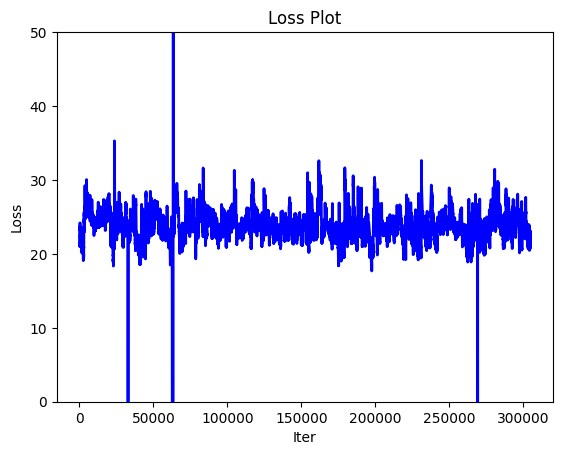

In [7]:
#Loss plot
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(losses, color='blue', linewidth=2)
ax.set_xlabel('Iter')
ax.set_ylabel('Loss')
ax.set_ylim([0, 50])
ax.set_title('Loss Plot')
plt.show()

In [ ]:
#hugging face time series transformer documentation

import torch
from transformers import TimeSeriesTransformerForPrediction

model = TimeSeriesTransformerForPrediction.from_pretrained("huggingface/time-series-transformer-tourism-monthly")

# during training, one provides both past and future values
# as well as possible additional features
outputs = model(
    past_values=batch["past_values"],
    past_time_features=batch["past_time_features"],
    past_observed_mask=batch["past_observed_mask"],
    static_categorical_features=batch["static_categorical_features"],
    static_real_features=batch["static_real_features"],
    future_values=batch["future_values"],
    future_time_features=batch["future_time_features"],
)

loss = outputs.loss
loss.backward()

# during inference, one only provides past values
# as well as possible additional features
# the model autoregressively generates future values
outputs = model.generate(
    past_values=batch["past_values"],
    past_time_features=batch["past_time_features"],
    past_observed_mask=batch["past_observed_mask"],
    static_categorical_features=batch["static_categorical_features"],
    static_real_features=batch["static_real_features"],
    future_time_features=batch["future_time_features"],
)

mean_prediction = outputs.sequences.mean(dim=1)